In [1]:
# Import standard libraries
import numpy as np
import matplotlib.pyplot as plt
import copy
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import os

from tqdm import tqdm

# Import environment
import gym

# Import your TD3 components
from actor import Actor
from critic import Critic
from memory import ReplayBuffer
from td3 import TD3
from utils import OUNoise
from pink_noise import PinkNoise

In [2]:
# Define the list of environments to evaluate
env_names = ["Pendulum-v1", "MountainCarContinuous-v0"]

# Define a base seed for reproducibility
base_seed = 42

# Initialize a dictionary to store environment details
env_details = {}

for env_name in env_names:
    env = gym.make(env_name)
    
    # Set seeds for reproducibility
    env.seed(base_seed)
    env.action_space.seed(base_seed)
    torch.manual_seed(base_seed)
    np.random.seed(base_seed)
    
    # Get environment dimensions
    state_dim = env.observation_space.shape[0]
    action_dim = env.action_space.shape[0]
    max_action = float(env.action_space.high[0])
    
    env_details[env_name] = {
        "env": env,
        "state_dim": state_dim,
        "action_dim": action_dim,
        "max_action": max_action
    }
    
    print(f"Environment: {env_name}")
    print(f"  State Dimension: {state_dim}")
    print(f"  Action Dimension: {action_dim}")
    print(f"  Max Action: {max_action}\n")


Environment: Pendulum-v1
  State Dimension: 3
  Action Dimension: 1
  Max Action: 2.0

Environment: MountainCarContinuous-v0
  State Dimension: 2
  Action Dimension: 1
  Max Action: 1.0



In [3]:
# Define training parameters common to all environments
training_params = {
    "discount": 0.99,
    "tau": 0.005,
    "policy_noise": 0.2,
    "noise_clip": 0.5,
    "policy_freq": 2,
}

# Define training settings
training_settings = {
    "max_episodes": 150,           # Total training episodes per environment
    "start_timesteps": 1000,        # Number of initial random steps
    "eval_freq": 50,                # How often to evaluate the policy (in episodes)
    "batch_size": 256,              # Batch size for training
    "expl_noise_type": "pink",      # Type of exploration noise: "gaussian" or "pink"
    "expl_noise": 0.1,              # Exploration noise scale
    "pink_noise_params": {          # Pink noise specific parameters
        "exponent": 1.0,            # Exponent for pink noise (1.0 for pink)
        "fmin": 0.0                 # Low-frequency cutoff
    },
    "use_layer_norm": True,         # Toggle LayerNorm on/off
    "ln_eps": 1e-5,                 # LayerNorm epsilon
    "save_model": True,             # Whether to save the model
    "save_model_freq": 100          # How often to save the model (in episodes)
}


# Directory setup
base_results_dir = "./results"
base_models_dir = "./models"

if not os.path.exists(base_results_dir):
    os.makedirs(base_results_dir)

if training_settings["save_model"] and not os.path.exists(base_models_dir):
    os.makedirs(base_models_dir)

# Initialize a dictionary to store agents and replay buffers
agents = {}
replay_buffers = {}

In [4]:
# Initialize TD3 agents and Replay Buffers for each environment
noise_generators = {}

for env_name, details in env_details.items():
    state_dim = details["state_dim"]
    action_dim = details["action_dim"]
    max_action = details["max_action"]
    
    # Initialize TD3 agent
    agent = TD3(
        state_dim=state_dim,
        action_dim=action_dim,
        max_action=max_action,
        discount=training_params["discount"],
        tau=training_params["tau"],
        policy_noise=training_params["policy_noise"],
        noise_clip=training_params["noise_clip"],
        policy_freq=training_params["policy_freq"],
        use_layer_norm=training_settings["use_layer_norm"],
        ln_eps=training_settings["ln_eps"]
    )
    
    agents[env_name] = agent
    
    # Initialize Replay Buffer
    replay_buffer = ReplayBuffer(state_dim, action_dim, max_size=int(1e6))
    replay_buffers[env_name] = replay_buffer

    if training_settings["expl_noise_type"] == "pink":
        max_steps = details["env"].spec.max_episode_steps
        noise_gen = PinkNoise(
            action_dim=details["action_dim"],
            max_steps=max_steps,
            exponent=training_settings["pink_noise_params"]["exponent"],
            fmin=training_settings["pink_noise_params"]["fmin"]
        )
        noise_generators[env_name] = noise_gen
        print(f"Initialized PinkNoise for {env_name} with exponent={training_settings['pink_noise_params']['exponent']} and fmin={training_settings['pink_noise_params']['fmin']}")
    else:
        noise_generators[env_name] = None  # No noise generator needed for Gaussian
    
    print(f"Initialized TD3 agent and Replay Buffer for {env_name}")

Initialized PinkNoise for Pendulum-v1 with exponent=1.0 and fmin=0.0
Initialized TD3 agent and Replay Buffer for Pendulum-v1
Initialized PinkNoise for MountainCarContinuous-v0 with exponent=1.0 and fmin=0.0
Initialized TD3 agent and Replay Buffer for MountainCarContinuous-v0


In [5]:
def eval_policy(policy, env, seed, eval_episodes=10):
    """
    Evaluates the policy over a number of episodes.

    Args:
        policy (TD3): The trained TD3 agent.
        env (gym.Env): The environment to evaluate on.
        seed (int): The seed for reproducibility.
        eval_episodes (int): Number of episodes to evaluate.

    Returns:
        list: List of episode rewards.
    """
    eval_env = copy.deepcopy(env)
    eval_env.seed(seed + 100)
    eval_env.action_space.seed(seed + 100)

    # Set networks to eval mode
    policy.actor.eval()
    policy.critic.eval()

    episode_rewards = []
    with torch.no_grad():
        for _ in range(eval_episodes):
            state, done = eval_env.reset(), False
            episode_reward = 0
            while not done:
                action = policy.select_action(np.array(state))
                state, reward, done, _ = eval_env.step(action)
                episode_reward += reward
            episode_rewards.append(episode_reward)

    # Restore networks to train mode
    policy.actor.train()
    policy.critic.train()

    print("---------------------------------------")
    print(f"Evaluation over {eval_episodes} episodes: Rewards: {episode_rewards}")
    print("---------------------------------------")
    return episode_rewards


def evaluate_trained_actor(policy, env, seed, eval_episodes=100):
    """
    Evaluates the trained actor over 100 episodes and computes mean and std of rewards.

    Args:
        policy (TD3): The trained TD3 agent.
        env (gym.Env): The environment to evaluate on.
        seed (int): The seed for reproducibility.
        eval_episodes (int): Number of episodes to evaluate.

    Returns:
        tuple: (list of episode rewards, mean reward, std reward)
    """
    eval_env = copy.deepcopy(env)
    eval_env.seed(seed + 200)
    eval_env.action_space.seed(seed + 200)

    policy.actor.eval()

    episode_rewards = []
    with torch.no_grad():
        for episode in range(eval_episodes):
            state, done = eval_env.reset(), False
            episode_reward = 0
            while not done:
                action = policy.select_action(np.array(state))
                state, reward, done, _ = eval_env.step(action)
                episode_reward += reward
            episode_rewards.append(episode_reward)
            if (episode + 1) % 10 == 0:
                print(f"Completed {episode + 1}/{eval_episodes} episodes.")

    mean_reward = np.mean(episode_rewards)
    std_reward = np.std(episode_rewards)

    print("---------------------------------------")
    print(f"Final Evaluation over {eval_episodes} episodes: Mean Reward: {mean_reward:.3f}, Std: {std_reward:.3f}")
    print("---------------------------------------")
    return episode_rewards, mean_reward, std_reward


In [6]:
# Initialize a dictionary to store evaluation results
evaluation_results = {}

for env_name, details in env_details.items():
    print(f"\n===========================\nTraining on {env_name}\n===========================")
    
    env = details["env"]
    state_dim = details["state_dim"]
    action_dim = details["action_dim"]
    max_action = details["max_action"]
    
    agent = agents[env_name]
    replay_buffer = replay_buffers[env_name]
    noise_gen = noise_generators[env_name]
    
    # Define file-specific directories
    file_name = f"TD3_{env_name.replace('-', '_')}_{base_seed}"
    results_dir = os.path.join(base_results_dir, env_name.replace('-', '_'))
    models_dir = os.path.join(base_models_dir, env_name.replace('-', '_'))
    
    if not os.path.exists(results_dir):
        os.makedirs(results_dir)
    
    if training_settings["save_model"] and not os.path.exists(models_dir):
        os.makedirs(models_dir)
    
    # Evaluate untrained policy
    print("Evaluating untrained policy...")
    initial_evaluations = eval_policy(agent, env, base_seed, eval_episodes=10)
    evaluations = initial_evaluations.copy()
    
    state, done = env.reset(), False
    episode_reward = 0
    episode_timesteps = 0
    episode_num = 0
    total_timesteps = 0  # To track total timesteps if needed
    
    # Progress bar for episodes
    pbar = tqdm(total=training_settings["max_episodes"], desc=f"Training {env_name}")
    
    for episode in range(1, training_settings["max_episodes"] + 1):
        state = env.reset()
        done = False
        episode_reward = 0
        episode_timesteps = 0
        
        # Reset noise generator if using pink noise
        if training_settings["expl_noise_type"] == "pink" and noise_gen is not None:
            noise_gen.reset()
        
        while not done:
            episode_timesteps += 1
            total_timesteps += 1
            
            # Select action
            if total_timesteps < training_settings["start_timesteps"]:
                action = env.action_space.sample()
            else:
                action = agent.select_action(np.array(state))
                
                if training_settings["expl_noise_type"] == "gaussian":
                    # Add Gaussian noise
                    noise = np.random.normal(0, training_settings["expl_noise"], size=action_dim)
                    action = (action + noise).clip(-max_action, max_action)
                elif training_settings["expl_noise_type"] == "pink" and noise_gen is not None:
                    # Add Pink noise
                    pink_noise = noise_gen.get_noise() * training_settings["expl_noise"]
                    action = (action + pink_noise).clip(-max_action, max_action)
            
            # Perform action
            next_state, reward, done, _ = env.step(action)
            done_bool = float(done) if episode_timesteps < env.spec.max_episode_steps else 0
            
            # Store data in replay buffer
            replay_buffer.add(state, action, next_state, reward, done_bool)
            
            state = next_state
            episode_reward += reward
            
            # Train agent after collecting sufficient data
            if total_timesteps >= training_settings["start_timesteps"]:
                agent.train(replay_buffer, training_settings["batch_size"])
        
        # Append the episode reward
        evaluations.append(episode_reward)
        
        # Update the progress bar
        pbar.update(1)
        
        # Evaluate the policy at specified intervals
        if episode % training_settings["eval_freq"] == 0:
            print(f"Evaluating policy at episode {episode}...")
            eval_rewards = eval_policy(agent, env, base_seed, eval_episodes=10)
            evaluations.extend(eval_rewards)  # Append evaluation rewards to the list
            np.save(os.path.join(results_dir, file_name), evaluations)
            if training_settings["save_model"] and (episode % training_settings["save_model_freq"] == 0):
                agent.save(os.path.join(models_dir, file_name))
        
        # Optionally, save the model at the end of training
        if training_settings["save_model"] and (episode == training_settings["max_episodes"]):
            agent.save(os.path.join(models_dir, file_name))
    
    pbar.close()
    
    # Store evaluations for plotting later
    evaluation_results[env_name] = evaluations




Training on Pendulum-v1
Evaluating untrained policy...
---------------------------------------
Evaluation over 10 episodes: Rewards: [-1431.158075604773, -1391.0529496864476, -1645.2609219742255, -1593.6801202291608, -1634.2729037466129, -1697.1217426386595, -1102.9597722287926, -1622.3250914562734, -1526.5359087071145, -1539.1747888627683]
---------------------------------------


Training Pendulum-v1:  33%|███▎      | 50/150 [00:34<01:16,  1.31it/s]

Evaluating policy at episode 50...
---------------------------------------
Evaluation over 10 episodes: Rewards: [-117.8060243875624, -128.28029672414553, -243.7852810396247, -115.3866579392135, -249.70276583380348, -231.01756476515638, -128.43210093575385, -240.71034607652967, -121.77012126805324, -117.96557446541048]
---------------------------------------


Training Pendulum-v1:  67%|██████▋   | 100/150 [01:13<00:38,  1.30it/s]

Evaluating policy at episode 100...
---------------------------------------
Evaluation over 10 episodes: Rewards: [-120.63885160366245, -132.31698424282783, -238.830138327085, -119.48371753316988, -248.61656938719767, -236.81182371442355, -125.45229954931423, -245.16768142025458, -124.63588243155488, -122.42173000767394]
---------------------------------------


Training Pendulum-v1: 100%|██████████| 150/150 [01:52<00:00,  1.31it/s]

Evaluating policy at episode 150...


Training Pendulum-v1: 100%|██████████| 150/150 [01:53<00:00,  1.33it/s]

---------------------------------------
Evaluation over 10 episodes: Rewards: [-128.65120353919346, -139.01883969366034, -244.13136648160736, -125.80854825712336, -251.2741414902245, -239.03820661265718, -133.2118184034543, -250.97247140278867, -132.37802670950194, -129.71259849677853]
---------------------------------------

Training on MountainCarContinuous-v0
Evaluating untrained policy...


---------------------------------------
Evaluation over 10 episodes: Rewards: [-4.899580654576741, -4.829483779915739, -4.799848554532104, -4.9518898440708, -4.87258430860185, -4.813835947064966, -4.84773310519361, -4.879622742323562, -4.869979849666217, -4.968297487508113]
---------------------------------------


Training MountainCarContinuous-v0:  33%|███▎      | 50/150 [03:07<06:21,  3.82s/it]

Evaluating policy at episode 50...
---------------------------------------
Evaluation over 10 episodes: Rewards: [-0.009824421421186677, -0.005298351179100002, -0.02511808213303237, -0.024950865486948866, -0.03561747667700368, -0.007726517830121676, -0.035988341131964086, -0.03530559203309575, -0.03573554201407301, -0.02822622558283115]
---------------------------------------


Training MountainCarContinuous-v0:  67%|██████▋   | 100/150 [06:20<03:07,  3.74s/it]

Evaluating policy at episode 100...
---------------------------------------
Evaluation over 10 episodes: Rewards: [-0.008515909421976258, -0.011566003645803388, -0.008747708444897426, -0.008939055451744725, -0.007866502404123812, -0.007871504506894124, -0.00793576423392577, -0.007944768881738003, -0.007846579874832326, -0.008900853196166791]
---------------------------------------


Training MountainCarContinuous-v0: 100%|██████████| 150/150 [09:34<00:00,  3.84s/it]

Evaluating policy at episode 150...


Training MountainCarContinuous-v0: 100%|██████████| 150/150 [09:36<00:00,  3.84s/it]

---------------------------------------
Evaluation over 10 episodes: Rewards: [-0.004582672930620834, -0.004635976716948248, -0.0032717205865816345, -0.0032718214423056555, -0.005193780434992833, -0.004832836928499752, -0.0052834692848588655, -0.005243955573605766, -0.0051819066863389735, -0.0033441163549013516]
---------------------------------------


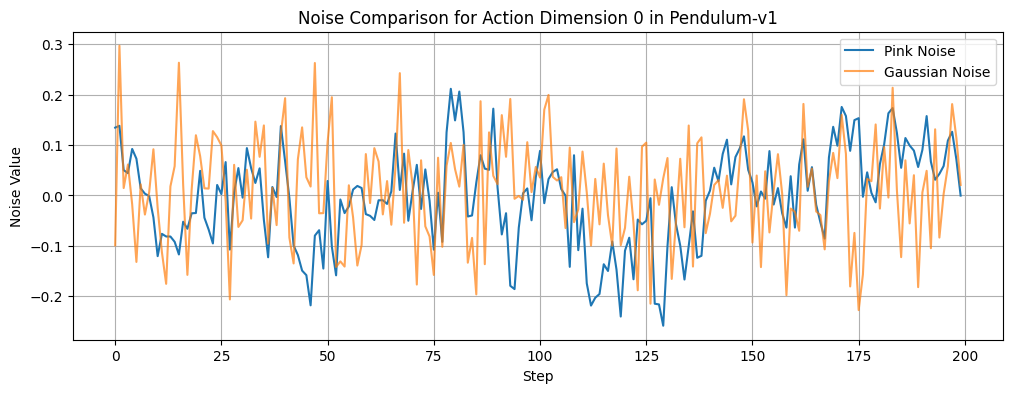

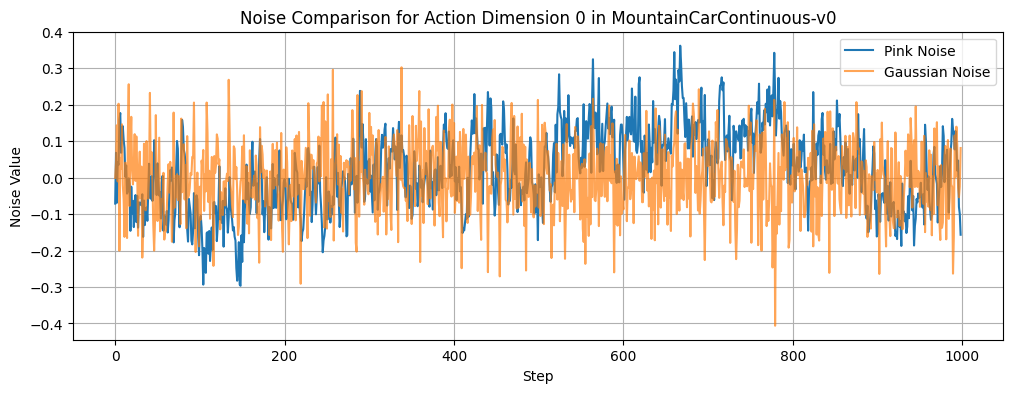

In [7]:
# Example: Plotting pink noise vs Gaussian noise for a single episode

import matplotlib.pyplot as plt

def plot_noise_comparison(env_name, noise_gen, training_settings):
    max_steps = env_details[env_name]["env"].spec.max_episode_steps
    action_dim = env_details[env_name]["action_dim"]
    
    # Reset noise generator
    noise_gen.reset()
    
    # Generate noise sequence
    pink_noise_sequence = []
    for _ in range(max_steps):
        pink_noise = noise_gen.get_noise() * training_settings["expl_noise"]
        pink_noise_sequence.append(pink_noise)
    pink_noise_sequence = np.array(pink_noise_sequence)
    
    # Generate Gaussian noise
    gaussian_noise_sequence = np.random.normal(0, training_settings["expl_noise"], size=(max_steps, action_dim))
    
    # Plot for each action dimension
    for dim in range(action_dim):
        plt.figure(figsize=(12, 4))
        plt.plot(pink_noise_sequence[:, dim], label='Pink Noise')
        plt.plot(gaussian_noise_sequence[:, dim], label='Gaussian Noise', alpha=0.7)
        plt.title(f'Noise Comparison for Action Dimension {dim} in {env_name}')
        plt.xlabel('Step')
        plt.ylabel('Noise Value')
        plt.legend()
        plt.grid(True)
        plt.show()

# Example usage after training
for env_name, noise_gen in noise_generators.items():
    if training_settings["expl_noise_type"] == "pink" and noise_gen is not None:
        plot_noise_comparison(env_name, noise_gen, training_settings)

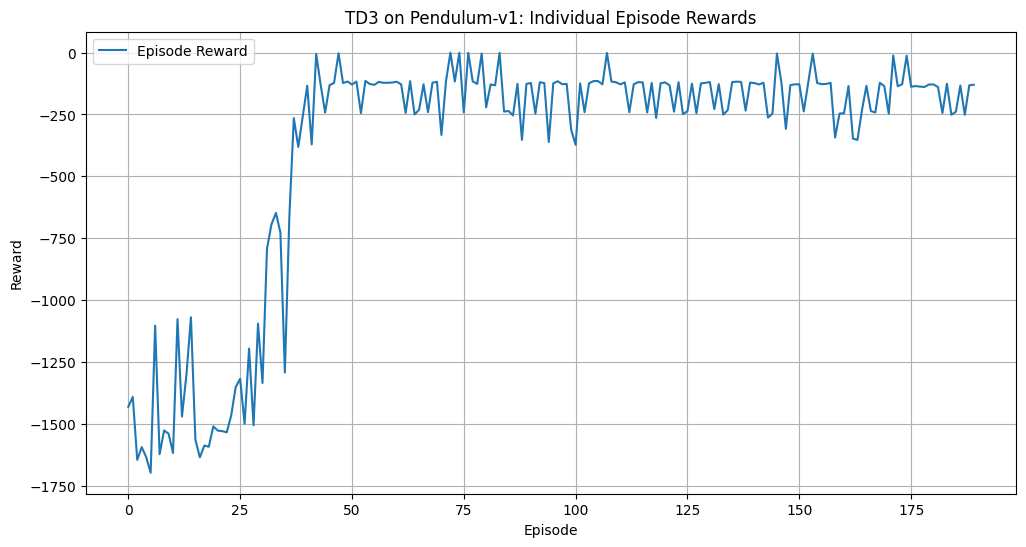

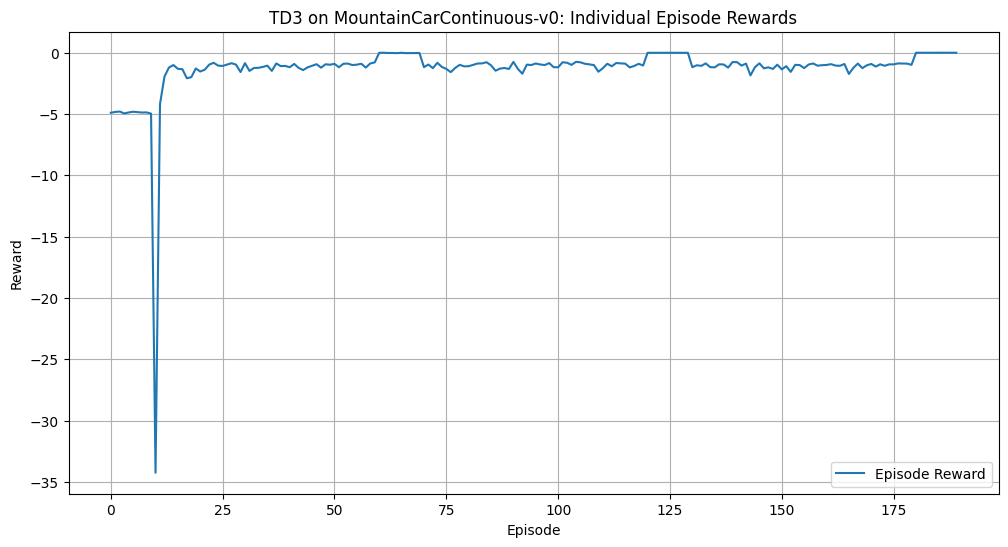

In [8]:
# Plotting individual episode rewards for each environment
for env_name, rewards in evaluation_results.items():
    plt.figure(figsize=(12,6))
    plt.plot(rewards, label='Episode Reward')
    plt.xlabel('Episode')
    plt.ylabel('Reward')
    plt.title(f'TD3 on {env_name}: Individual Episode Rewards')
    plt.legend()
    plt.grid(True)
    plt.show()

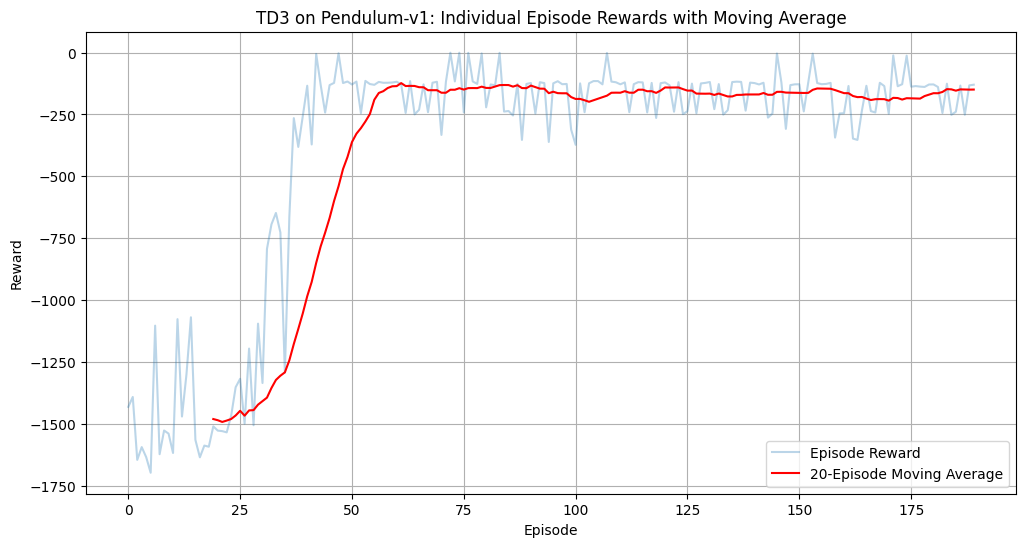

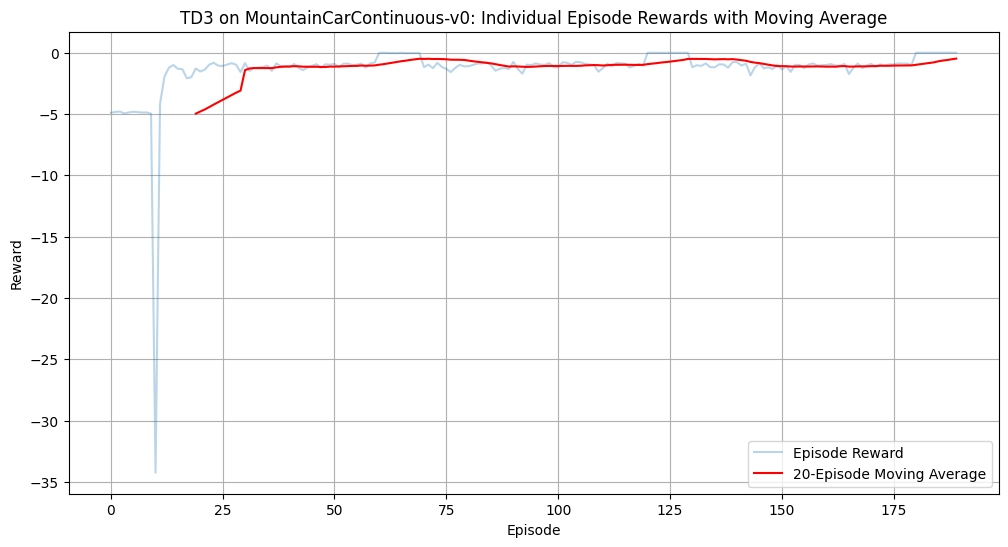

In [9]:
# Moving average for smoother visualization
window = 20

for env_name, rewards in evaluation_results.items():
    plt.figure(figsize=(12,6))
    plt.plot(rewards, label='Episode Reward', alpha=0.3)
    if len(rewards) >= window:
        moving_avg = np.convolve(rewards, np.ones(window)/window, mode='valid')
        plt.plot(range(window-1, len(rewards)), moving_avg, label=f'{window}-Episode Moving Average', color='red')
    plt.xlabel('Episode')
    plt.ylabel('Reward')
    plt.title(f'TD3 on {env_name}: Individual Episode Rewards with Moving Average')
    plt.legend()
    plt.grid(True)
    plt.show()


In [10]:
# Initialize a dictionary to store final evaluation results
final_evaluation_results = {}

for env_name, details in env_details.items():
    print(f"\n===========================\nFinal Evaluation on {env_name}\n===========================")
    
    env = details["env"]
    agent = agents[env_name]
    
    # Define file-specific directories
    file_name = f"TD3_{env_name.replace('-', '_')}_{base_seed}"
    results_dir = os.path.join(base_results_dir, env_name.replace('-', '_'))
    models_dir = os.path.join(base_models_dir, env_name.replace('-', '_'))
    
    # Load the trained actor (if not already in memory)
    # Uncomment the following line if running evaluations in a separate session
    # agent.load(os.path.join(models_dir, file_name))
    
    # Evaluate the trained actor
    final_episode_rewards, final_mean_reward, final_std_reward = evaluate_trained_actor(agent, env, base_seed, eval_episodes=100)
    
    # Store the results
    final_evaluation_results[env_name] = {
        "rewards": final_episode_rewards,
        "mean_reward": final_mean_reward,
        "std_reward": final_std_reward
    }



Final Evaluation on Pendulum-v1
Completed 10/100 episodes.
Completed 20/100 episodes.
Completed 30/100 episodes.
Completed 40/100 episodes.
Completed 50/100 episodes.
Completed 60/100 episodes.
Completed 70/100 episodes.
Completed 80/100 episodes.
Completed 90/100 episodes.
Completed 100/100 episodes.
---------------------------------------
Final Evaluation over 100 episodes: Mean Reward: -162.603, Std: 83.742
---------------------------------------

Final Evaluation on MountainCarContinuous-v0
Completed 10/100 episodes.
Completed 20/100 episodes.
Completed 30/100 episodes.
Completed 40/100 episodes.
Completed 50/100 episodes.
Completed 60/100 episodes.
Completed 70/100 episodes.
Completed 80/100 episodes.
Completed 90/100 episodes.
Completed 100/100 episodes.
---------------------------------------
Final Evaluation over 100 episodes: Mean Reward: -0.004, Std: 0.001
---------------------------------------


In [11]:
def render_episodes(policy, env, seed, episodes=5, render=True):
    """
    Renders the agent interacting with the environment.

    Args:
        policy (TD3): The trained TD3 agent.
        env (gym.Env): The environment to visualize.
        seed (int): Seed for reproducibility.
        episodes (int): Number of episodes to render.
        render (bool): Whether to render the environment.

    Returns:
        None
    """
    import copy
    import torch

    # Create a deep copy of the environment for rendering
    eval_env = copy.deepcopy(env)
    eval_env.seed(seed + 300)
    eval_env.action_space.seed(seed + 300)
    torch.manual_seed(seed + 300)

    # Set Actor and Critic to eval mode
    policy.actor.eval()
    policy.critic.eval()

    for ep in range(1, episodes + 1):
        state = eval_env.reset()
        done = False
        episode_reward = 0
        while not done:
            if render:
                eval_env.render()

            # Select action without exploration noise
            action = policy.select_action(np.array(state))
            
            # Take action in the environment
            state, reward, done, _ = eval_env.step(action)
            episode_reward += reward

        print(f"Episode {ep}: Reward = {episode_reward}")

    # Close the rendering window if necessary
    eval_env.close()

    # Restore Actor and Critic to train mode
    policy.actor.train()
    policy.critic.train()


In [12]:
# After training is complete

for env_name, details in env_details.items():
    env = details["env"]
    agent = agents[env_name]
    print(f"\nRendering episodes for {env_name}...")
    render_episodes(agent, env, base_seed, episodes=3, render=True)



Rendering episodes for Pendulum-v1...


NoSuchDisplayException: Cannot connect to "None"